# Summary

We will use PyMC3 to estimate the posterior PDF for the true rating of a set of artificial teams using data from a simulated season. The idea is to test our model on a small set of artificial data where we know the answer to begin with, so we can learn about MCMC and make sure our model is sensible.

In [1]:
import pandas as pd
import os
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
true_rating = {
    'All Stars': 2.0,
    'Average': 0.0,
    'Just Having Fun': -1.2,
}

true_index = {
    0: 'All Stars',
    1: 'Average',
    2: 'Just Having Fun',
}

n_teams = len(true_rating)
team_numbers = range(n_teams)
team_names = [true_index[i] for i in team_numbers]

In [3]:
true_rating

{'All Stars': 2.0, 'Average': 0.0, 'Just Having Fun': -1.2}

In [4]:
team_names

['All Stars', 'Average', 'Just Having Fun']

We have two teams, one of which is much better than the other. Let's make a simulated season between these teams.

In [5]:
season_length = [5, 20, 100]
traces = []
simulatedSeasons = []
for n_games in season_length:
    games = range(n_games)
    database = []
    for game in games:
        game_row = {}
        matchup = np.random.choice(team_numbers, size=2, replace=False)
        team0 = true_index[matchup[0]]
        team1 = true_index[matchup[1]]
        game_row['Team A'] = team0
        game_row['Team B'] = team1
        game_row['Index A'] = matchup[0]
        game_row['Index B'] = matchup[1]

        deltaRating = true_rating[team0] - true_rating[team1]

        p = 1 / (1 + np.exp(-deltaRating))

        randomNumber = np.random.random()

        outcome_A = p > randomNumber
        game_row['Team A Wins'] = outcome_A

        database.append(game_row)
    
    simulatedSeason = pd.DataFrame(database)
    simulatedSeasons.append(simulatedSeason)
    
    with pm.Model() as model:
        rating = pm.Normal('rating', mu=0, sd=1, shape=n_teams)

        deltaRating = rating[simulatedSeason['Index A'].values] - rating[simulatedSeason['Index B'].values]

        p = 1 / (1 + np.exp(-deltaRating))

        win = pm.Bernoulli('win', p, observed=simulatedSeason['Team A Wins'].values)
        
        trace = pm.sample(1000)
        
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating]
100%|██████████| 1500/1500 [00:01<00:00, 1121.17it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating]
100%|██████████| 1500/1500 [00:01<00:00, 1314.11it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating]
100%|██████████| 1500/1500 [00:01<00:00, 1029.69it/s]


In [136]:
simulatedSeasons[1].groupby('Team A').sum()

,Index A,Index B,Team A Wins
Team A,,,
All Stars,0,13,7.0
Average,4,6,2.0
Just Having Fun,16,6,1.0


In [135]:
1 / (1 + np.exp(-2))

0.88079707797788231

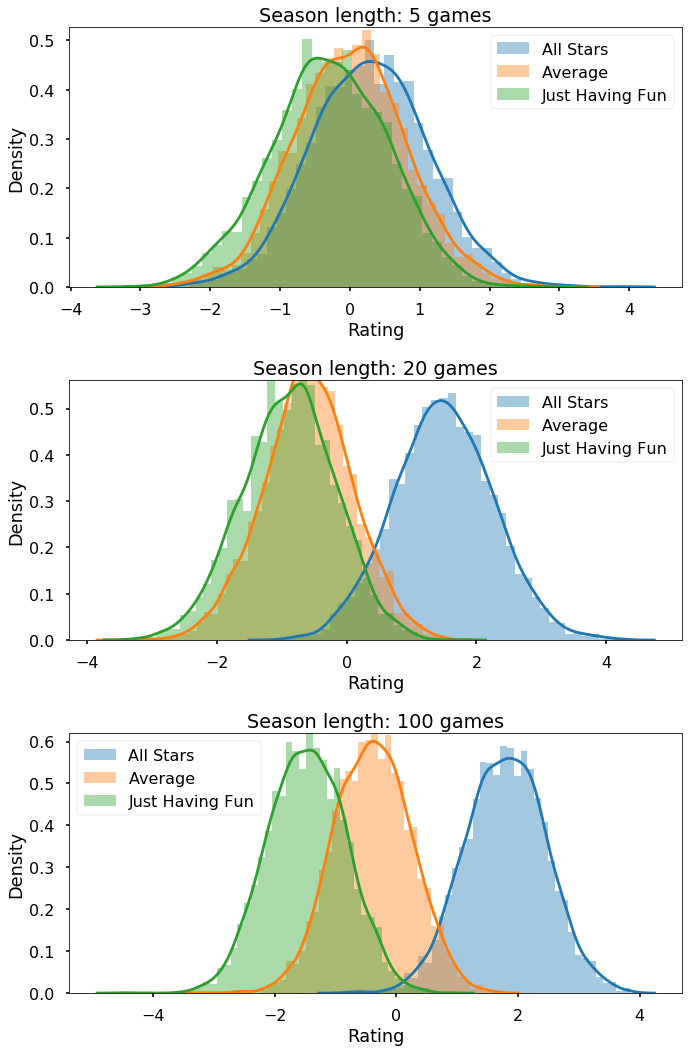

In [6]:
sns.set_context('poster')
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
# plt.figure(figsize=(10, 5))
for ax_index, n_games in enumerate(season_length):
    ax = axes[ax_index]
    for team_number in team_numbers:
        rating_posterior = traces[ax_index]['rating'][:, team_number]
        team_name = true_index[team_number]
        sns.distplot(rating_posterior, label=team_name, ax=ax)
    ax.legend()
    ax.set_xlabel('Rating')
    ax.set_ylabel('Density')
    ax.set_title("Season length: {} games".format(n_games))
plt.tight_layout()

In [97]:
simulatedSeason = pd.DataFrame(database)

In [98]:
simulatedSeason

,Index A,Index B,Team A,Team A Wins,Team B
0,1,0,Just Having Fun,False,All Stars
1,0,1,All Stars,True,Just Having Fun
2,1,0,Just Having Fun,False,All Stars
3,0,1,All Stars,True,Just Having Fun
4,1,0,Just Having Fun,False,All Stars
5,1,0,Just Having Fun,False,All Stars
6,0,1,All Stars,True,Just Having Fun
7,1,0,Just Having Fun,True,All Stars
8,0,1,All Stars,True,Just Having Fun
9,1,0,Just Having Fun,False,All Stars


In [75]:
project_dir = '/Users/rbussman/Projects/BUDA/buda-ratings'
scores_dir = os.path.join(project_dir, 'data', 'raw', 'game_scores')
simulatedSeason.to_csv(os.path.join(scores_dir, 'artificial_scores_big.csv'))

Prior on each team is a normal distribution with mean of 0 and standard deviation of 1.

In [99]:
simulatedSeason.shape

(10, 5)

In [100]:
with pm.Model() as model:
    rating = pm.Normal('rating', mu=0, sd=1, shape=n_teams)

    deltaRating = rating[simulatedSeason['Index A'].values] - rating[simulatedSeason['Index B'].values]
       
    p = 1 / (1 + np.exp(-deltaRating))
    
    win = pm.Bernoulli('win', p, observed=simulatedSeason['Team A Wins'].values)

In [101]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rating]
100%|██████████| 1500/1500 [00:00<00:00, 1586.93it/s]


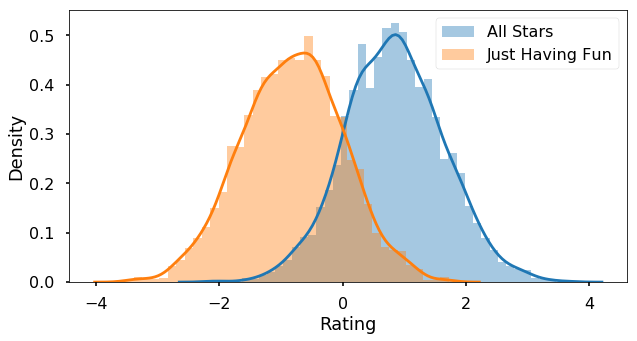

In [113]:
sns.set_context('poster')
plt.figure(figsize=(10, 5))
for team_number in team_numbers:
    rating_posterior = trace['rating'][:, team_number]
    team_name = true_index[team_number]
    sns.distplot(rating_posterior, label=team_name)
plt.legend()
plt.xlabel('Rating')
plt.ylabel('Density')

Hmm, something looks odd here. The posterior pdf for these two teams has significant overlap. Does this mean that our model is not sure about which team is better?

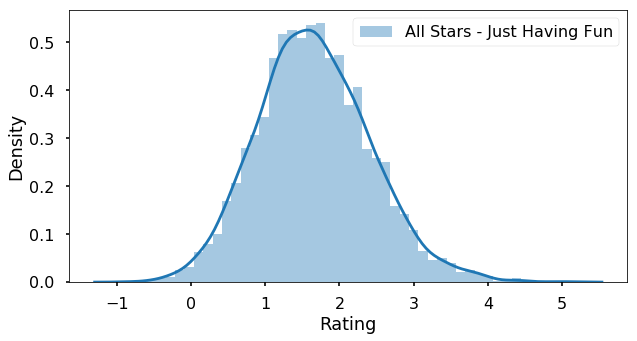

In [114]:
sns.set_context('poster')
plt.figure(figsize=(10, 5))
for team_number in team_numbers[:-1]:
    rating_posterior = trace['rating'][:, team_number] - trace['rating'][:, -1]
    team_name = true_index[team_number]
    sns.distplot(rating_posterior, label="{} - {}".format(team_name, true_index[team_numbers[-1]]))
plt.legend()
plt.xlabel('Rating')
plt.ylabel('Density')

In [119]:
gt0 = rating_posterior > 0
print("Percentage of samples where 'All Stars' have a higher rating than 'Just Having Fun': {:.2f}%".format(
    100. * rating_posterior[gt0].size / rating_posterior.size))

Percentage of samples where 'All Stars' have a higher rating than 'Just Having Fun': 99.22%


Ah, so the posterior pdf is actually quite clear: There is a 99.22% chance that "All Stars" are better than "Just Having Fun".

How does our confidence change as a function of the number of games in the season?

In [104]:
rating_posterior

array([ 1.35253041,  2.20214716,  2.55056653, ...,  2.2638182 ,
       -0.15597247,  0.4021902 ])

In [88]:
.75 ** 14

0.017817948013544083

In [82]:
estimatedratings = trace['rating'].mean(axis=0)

In [83]:
estimatedratings

array([ 1.50334729,  0.49968655, -0.73728304, -1.23310912])

In [47]:
for key in true_rating:
    print("True: {:.2f}; Estimated: {:.2f}".format((true_rating[key], estimatedratings[key]))

SyntaxError: invalid syntax (<ipython-input-47-538968eb2796>, line 2)

In [22]:
key

2